In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import SDEFactory
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.plotting import plot_landmark_sample_path
from neuralbridge.utils.t_grid import TimeGrid

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### Visualizations of different processes

In [3]:
X_brownian_unc = SDEFactory(
    config=OmegaConf.create({
        "sde": {
            "name": "brownian",
            "X_dim": 50 * 2,
            "W_dim": 50 * 2,
            "T": 1.0,
            "dt": 0.01,
            "t_scheme": "linear",
            "params_X_unc": {
                "gamma": 0.0,
                "sigma": 0.2,
            },
        }
    })
).get_original_sde()

X_lagrangian_unc = SDEFactory(
    config=OmegaConf.create({
        "sde": {
            "name": "landmark",
            "n_landmarks": 50,
            "X_dim": 50 * 2,
            "W_dim": 50 * 2,
            "T": 1.0,
            "dt": 0.01,
            "t_scheme": "linear",
            "params_X_unc": {
                "k_alpha": 0.3,
                "k_sigma": 0.5,
                "n_landmarks": 50,
                "m_landmarks": 2
            }
        }
    })
).get_original_sde()

In [3]:
config = read_config("../configs/landmark_ellipse.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)
u_closed = jnp.concatenate([u, u[:2]]).reshape(-1, 2)
v_closed = jnp.concatenate([v, v[:2]]).reshape(-1, 2)

{'sde': {'name': 'landmark', 'n_landmarks': 50, 'T': 1.0, 'dt': 0.01, 'X_dim': 100, 'W_dim': 100, 't_scheme': 'linear', 'params_X_unc': {'k_alpha': 0.3, 'k_sigma': 0.5, 'n_landmarks': 50, 'm_landmarks': 2}, 'params_X_aux': {'k_alpha': 0.3, 'k_sigma': 0.5, 'n_landmarks': 50, 'm_landmarks': 2}, 'u': [0.0, 0.5, 0.12533323466777802, 0.4960573613643646, 0.2486899048089981, 0.48429158329963684, 0.3681245744228363, 0.46488824486732483, 0.48175370693206787, 0.43815332651138306, 0.5877852439880371, 0.404508501291275, 0.6845471858978271, 0.3644842803478241, 0.7705132961273193, 0.3187119662761688, 0.8443279266357422, 0.2679133713245392, 0.9048271179199219, 0.21288959681987762, 0.9510565400123596, 0.15450848639011383, 0.9822872877120972, 0.09369061887264252, 0.9980267286300659, 0.031395189464092255, 0.9980267286300659, -0.03139529377222061, 0.9822872281074524, -0.09369071573019028, 0.9510564804077148, -0.15450851619243622, 0.9048269987106323, -0.2128896862268448, 0.8443278670310974, -0.26791346073

unconditional process plotting

In [6]:
tGrid = TimeGrid(
    T=config.sde.T,
    dt=config.sde.dt,
    t_scheme=config.sde.t_scheme
)
W = WienerProcess(
    config.sde.W_dim
)

In [6]:
X_brownian_unc_solver = Euler(X_brownian_unc, W, tGrid)
X_brownian_unc_path = X_brownian_unc_solver.solve(x0=u, batch_size=4)
X_lagrangian_unc_solver = Euler(X_lagrangian_unc, W, tGrid)
X_lagrangian_unc_path = X_lagrangian_unc_solver.solve(x0=u, batch_size=4)

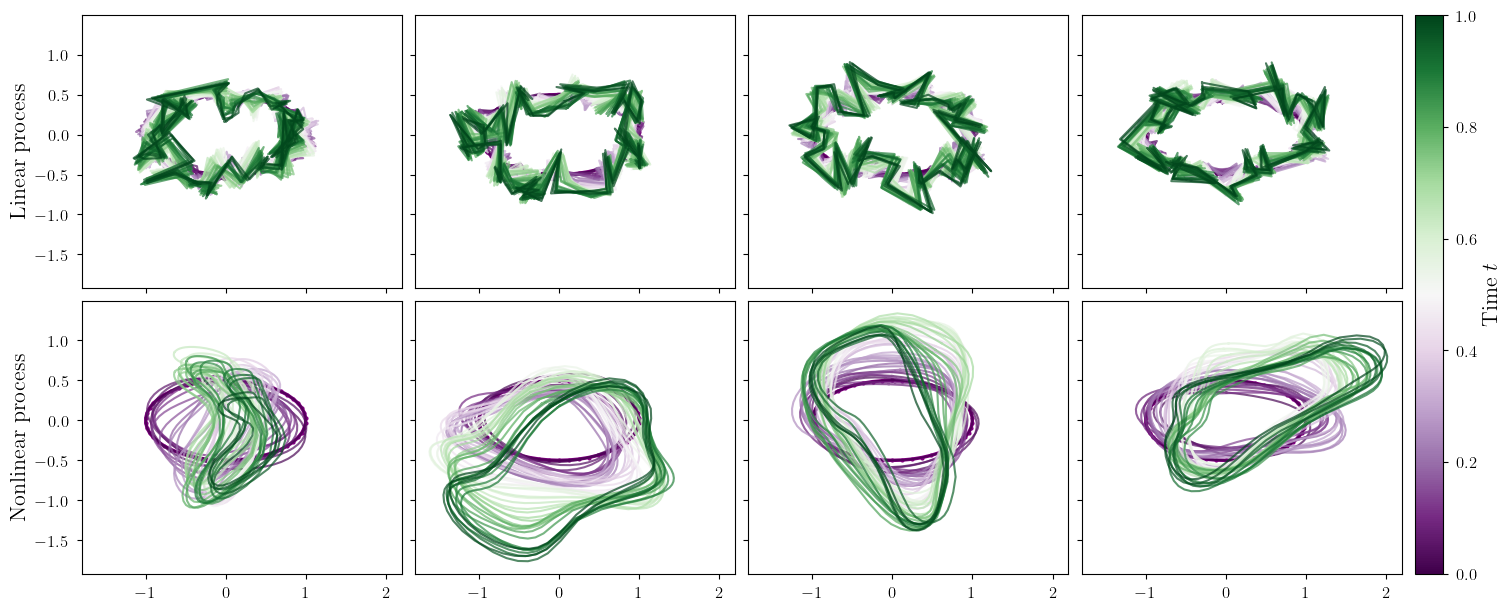

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True, layout="constrained")
axes[0, 0].set_ylabel(r'Linear process', fontsize=16)
axes[1, 0].set_ylabel(r'Nonlinear process', fontsize=16)

for i, ax in enumerate(axes[0]):
    ax.plot(*u_closed.T, '-o', color="purple", alpha=1.0, linewidth=2.5, markersize=3, label=r'$u$')
    ax, mappable = plot_landmark_sample_path(
        X_brownian_unc_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_shapes=True,
        show_intermediate_trajectories=False,
        markersize=10,
        alpha=0.7,
        show_every=2,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.tick_params(axis='both', which='major', labelsize=12)
    
for i, ax in enumerate(axes[1]):
    ax.plot(*u_closed.T, '-o', color="purple", alpha=1.0, linewidth=2.5, markersize=3, label=r'$u$')
    ax, mappable = plot_landmark_sample_path(
        X_lagrangian_unc_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_shapes=True,
        show_intermediate_trajectories=False,
        markersize=10,
        alpha=0.7,
        show_every=2,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'Time $t$', pad=0.01)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Time $t$', fontsize=16)
fig.savefig("../assets/figures/landmark_model/ellipse_unconditional_samples.pdf", dpi=300, bbox_inches="tight")

#### Neural bridge

In [7]:
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(x0=u, batch_size=16)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/landmark_ellipse_50_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


#### Pre-conditioned Crank-Nicolson

In [13]:
config = read_config("../configs/landmark_ellipse.yaml")

config.mcmc.n_chains = 4
config.mcmc.eta = 0.98
config.mcmc.n_iters = 2500
pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
_, pcn_result = pcn_model.run()
X_pcn_path = pcn_result.path

Running pCN: 100%|██████████| 2500/2500 [02:26<00:00, 17.11it/s]
INFO:root:Batch average acceptance rate: 21.44%


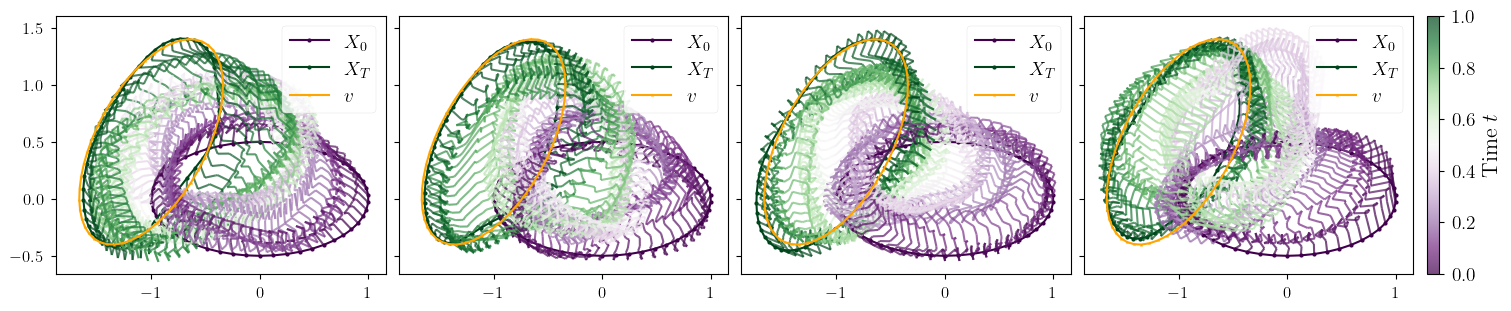

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharey=True, sharex=True, layout="constrained")

for i, ax in enumerate(axes):
    _, mappable = plot_landmark_sample_path(
        X_neu_path[i+4],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_trajectories=True,
        show_intermediate_shapes=False,
        markersize=3,
        alpha=0.7,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'Time $t$', pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Time $t$', fontsize=16)
fig.savefig("../assets/figures/landmark_model/ellipse_neural_bridge_samples.pdf", dpi=300, bbox_inches="tight")

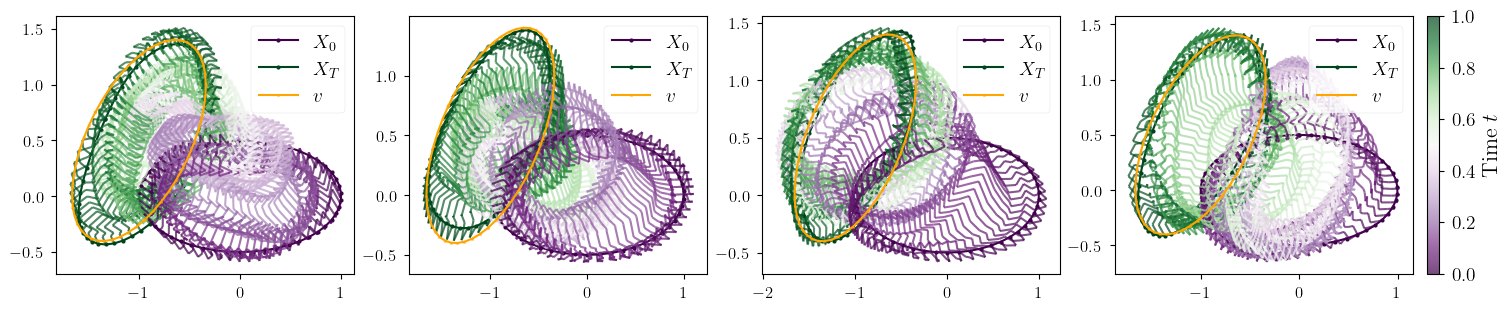

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained")

for i, ax in enumerate(axes):
    _, mappable = plot_landmark_sample_path(
        X_pcn_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="PRGn",
        show_intermediate_trajectories=True,
        show_intermediate_shapes=False,
        markersize=3,
        alpha=0.7,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'Time $t$', pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Time $t$', fontsize=16)
fig.savefig("../assets/figures/landmark_model/ellipse_pcn_samples.pdf", dpi=300, bbox_inches="tight")